In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pubchempy as pcp
import re

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm 

In [10]:
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

GPU device: NVIDIA GeForce RTX 2070 SUPER
GPU memory: 8.00 GB
Using device: cuda


In [16]:
def extract_direction(description):
    desc = description.lower()
    if re.search(r"\bincreas(e|ed)\b", desc):
        return "increased"
    
    if re.search(r"\bdecreas(e|ed)\b|\breduced\b", desc):
        return "decreased"
    
    return "other"

In [17]:
# add interaction label to dataset
df = pd.read_csv('drug_interactions_cleaned.csv')

df['Direction'] = df['Interaction Description'].apply(extract_direction)
print(df['Direction'].value_counts())

le = LabelEncoder()
df['Interaction_Label'] = le.fit_transform(df['Direction'])

num_classes = len(le.classes_)
print(f"Number of classes for training: {num_classes}")

df.to_csv('drug_interactions_direction.csv', index=False)

Direction
increased    128533
decreased     61399
Name: count, dtype: int64
Number of classes for training: 2


In [18]:
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
        fp = gen.GetFingerprint(mol)
        return np.array(fp)
    except:
        return None

In [72]:
df = pd.read_csv('drug_interactions_direction.csv')
print("Checking loaded data:")
print(df['Direction'].value_counts())
print(df['Interaction_Label'].value_counts())
print(f"Unique labels: {df['Interaction_Label'].unique()}")

unique_smiles = pd.concat([df['Drug1_SMILES'], df['Drug2_SMILES']]).unique()

smiles_to_fp_dict = {}
for smiles in tqdm(unique_smiles):
    fp = smiles_to_fingerprint(smiles)
    smiles_to_fp_dict[smiles] = fp

df['Drug1_FP'] = df['Drug1_SMILES'].map(smiles_to_fp_dict)
df['Drug2_FP'] = df['Drug2_SMILES'].map(smiles_to_fp_dict)

before_removal = len(df)
df = df.dropna(subset=['Drug1_FP', 'Drug2_FP'])
print(f"Removed: {before_removal - len(df)} rows with failed fingerprints")

Checking loaded data:
Direction
increased    128533
decreased     61399
Name: count, dtype: int64
Interaction_Label
1    128533
0     61399
Name: count, dtype: int64
Unique labels: [0 1]


 29%|██▉       | 485/1656 [00:00<00:01, 979.87it/s][18:25:24] WARNING: not removing hydrogen atom without neighbors
[18:25:24] WARNING: not removing hydrogen atom without neighbors
 60%|██████    | 997/1656 [00:01<00:00, 1009.00it/s][18:25:25] WARNING: not removing hydrogen atom without neighbors
[18:25:25] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 1656/1656 [00:01<00:00, 985.76it/s]


Removed: 0 rows with failed fingerprints


In [20]:
X1 = np.stack(df['Drug1_FP'].values).astype(np.float32)
X2 = np.stack(df['Drug2_FP'].values).astype(np.float32)
y = df['Interaction_Label'].values.astype(np.int64)

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)

KeyError: 'Drug1_FP'

In [19]:
class DDIDataset(Dataset):
    def __init__(self, drug1_fps, drug2_fps, labels):
        self.drug1_fps = torch.FloatTensor(drug1_fps)
        self.drug2_fps = torch.FloatTensor(drug2_fps)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.drug1_fps[idx], self.drug2_fps[idx], self.labels[idx]

train_dataset = DDIDataset(X1_train, X2_train, y_train)
test_dataset = DDIDataset(X1_test, X2_test, y_test)

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

NameError: name 'X1_train' is not defined

In [11]:
class DDIPredictor(nn.Module):
    def __init__(self, num_classes=2):
        super(DDIPredictor, self).__init__()
        
        self.drug_encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=8, stride=1, padding=4),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 128, kernel_size=8, stride=1, padding=4),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=4),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            
            nn.Conv1d(256, 512, kernel_size=8, stride=1, padding=4),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.AdaptiveMaxPool1d(1)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 2, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.4),
            
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            
            nn.Linear(512, num_classes)
        )
    
    def forward(self, drug1, drug2):
        drug1 = drug1.unsqueeze(1)  # (batch, 1, 2048)
        drug2 = drug2.unsqueeze(1)  # (batch, 1, 2048)
    
        drug1_features = self.drug_encoder(drug1).squeeze(-1)  # (batch, 512)
        drug2_features = self.drug_encoder(drug2).squeeze(-1)  # (batch, 512)
        
        combined = torch.cat([drug1_features, drug2_features], dim=1)
        output = self.fc_layers(combined)

        return output

model = DDIPredictor(num_classes=2).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for drug1, drug2, labels in pbar:
        drug1, drug2, labels = drug1.to(device), drug2.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(drug1, drug2)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * drug1.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': correct/total})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [80]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for drug1, drug2, labels in loader:
            drug1, drug2, labels = drug1.to(device), drug2.to(device), labels.to(device)
            
            outputs = model(drug1, drug2)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * drug1.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [81]:
num_epochs = 20

best_val_acc = 0.0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print(f"New best model saved (Val Acc: {val_acc:.4f})")
    print()

print(f"Best validation accuracy: {best_val_acc:.4f}")

Starting training...



Training: 100%|██████████| 2375/2375 [02:57<00:00, 13.35it/s, loss=0.253, acc=0.8]  


Epoch [1/20] LR: 0.001000
  Train Loss: 0.4307 | Train Acc: 0.8003
  Val Loss:   0.3210 | Val Acc:   0.8613
New best model saved (Val Acc: 0.8613)



Training: 100%|██████████| 2375/2375 [02:53<00:00, 13.70it/s, loss=0.31, acc=0.872] 


Epoch [2/20] LR: 0.001000
  Train Loss: 0.2961 | Train Acc: 0.8717
  Val Loss:   0.2416 | Val Acc:   0.8968
New best model saved (Val Acc: 0.8968)



Training: 100%|██████████| 2375/2375 [02:51<00:00, 13.89it/s, loss=0.372, acc=0.891] 


Epoch [3/20] LR: 0.001000
  Train Loss: 0.2526 | Train Acc: 0.8914
  Val Loss:   0.2515 | Val Acc:   0.9042
New best model saved (Val Acc: 0.9042)



Training: 100%|██████████| 2375/2375 [02:50<00:00, 13.92it/s, loss=0.112, acc=0.902] 


Epoch [4/20] LR: 0.001000
  Train Loss: 0.2299 | Train Acc: 0.9018
  Val Loss:   0.3516 | Val Acc:   0.9148
New best model saved (Val Acc: 0.9148)



Training: 100%|██████████| 2375/2375 [02:49<00:00, 14.02it/s, loss=0.258, acc=0.91]  


Epoch [5/20] LR: 0.001000
  Train Loss: 0.2110 | Train Acc: 0.9104
  Val Loss:   0.2170 | Val Acc:   0.9173
New best model saved (Val Acc: 0.9173)



Training: 100%|██████████| 2375/2375 [02:47<00:00, 14.19it/s, loss=0.37, acc=0.914]  


Epoch [6/20] LR: 0.001000
  Train Loss: 0.2020 | Train Acc: 0.9145
  Val Loss:   1.5900 | Val Acc:   0.9248
New best model saved (Val Acc: 0.9248)



Training: 100%|██████████| 2375/2375 [02:47<00:00, 14.18it/s, loss=0.219, acc=0.916] 


Epoch [7/20] LR: 0.001000
  Train Loss: 0.1996 | Train Acc: 0.9159
  Val Loss:   0.5119 | Val Acc:   0.9269
New best model saved (Val Acc: 0.9269)



Training: 100%|██████████| 2375/2375 [02:48<00:00, 14.11it/s, loss=0.103, acc=0.921] 


Epoch [8/20] LR: 0.001000
  Train Loss: 0.1868 | Train Acc: 0.9205
  Val Loss:   1.6963 | Val Acc:   0.9354
New best model saved (Val Acc: 0.9354)



Training: 100%|██████████| 2375/2375 [02:47<00:00, 14.21it/s, loss=0.0427, acc=0.923]


Epoch [9/20] LR: 0.001000
  Train Loss: 0.1853 | Train Acc: 0.9227
  Val Loss:   1.8053 | Val Acc:   0.9355
New best model saved (Val Acc: 0.9355)



Training: 100%|██████████| 2375/2375 [02:47<00:00, 14.22it/s, loss=0.66, acc=0.925]  


Epoch [10/20] LR: 0.001000
  Train Loss: 0.1814 | Train Acc: 0.9248
  Val Loss:   0.7566 | Val Acc:   0.9330



Training: 100%|██████████| 2375/2375 [02:46<00:00, 14.27it/s, loss=0.228, acc=0.924] 


Epoch [11/20] LR: 0.001000
  Train Loss: 0.1820 | Train Acc: 0.9240
  Val Loss:   0.1705 | Val Acc:   0.9376
New best model saved (Val Acc: 0.9376)



Training: 100%|██████████| 2375/2375 [02:48<00:00, 14.13it/s, loss=0.106, acc=0.926] 


Epoch [12/20] LR: 0.001000
  Train Loss: 0.1776 | Train Acc: 0.9260
  Val Loss:   0.1457 | Val Acc:   0.9389
New best model saved (Val Acc: 0.9389)



Training: 100%|██████████| 2375/2375 [02:47<00:00, 14.15it/s, loss=0.401, acc=0.926] 


Epoch [13/20] LR: 0.001000
  Train Loss: 0.1755 | Train Acc: 0.9265
  Val Loss:   0.1711 | Val Acc:   0.9414
New best model saved (Val Acc: 0.9414)



Training: 100%|██████████| 2375/2375 [02:47<00:00, 14.16it/s, loss=0.0213, acc=0.929]


Epoch [14/20] LR: 0.001000
  Train Loss: 0.1685 | Train Acc: 0.9293
  Val Loss:   0.1689 | Val Acc:   0.9370



Training: 100%|██████████| 2375/2375 [02:48<00:00, 14.11it/s, loss=0.167, acc=0.931] 


Epoch [15/20] LR: 0.001000
  Train Loss: 0.1646 | Train Acc: 0.9312
  Val Loss:   0.1472 | Val Acc:   0.9417
New best model saved (Val Acc: 0.9417)



Training: 100%|██████████| 2375/2375 [02:48<00:00, 14.09it/s, loss=0.121, acc=0.933] 


Epoch [16/20] LR: 0.001000
  Train Loss: 0.1617 | Train Acc: 0.9330
  Val Loss:   0.1381 | Val Acc:   0.9442
New best model saved (Val Acc: 0.9442)



Training: 100%|██████████| 2375/2375 [02:48<00:00, 14.09it/s, loss=0.436, acc=0.932] 


Epoch [17/20] LR: 0.001000
  Train Loss: 0.1648 | Train Acc: 0.9317
  Val Loss:   0.7761 | Val Acc:   0.9386



Training: 100%|██████████| 2375/2375 [02:49<00:00, 14.03it/s, loss=0.272, acc=0.931] 


Epoch [18/20] LR: 0.001000
  Train Loss: 0.1639 | Train Acc: 0.9309
  Val Loss:   0.1835 | Val Acc:   0.9427



Training: 100%|██████████| 2375/2375 [02:48<00:00, 14.10it/s, loss=0.382, acc=0.932] 


Epoch [19/20] LR: 0.001000
  Train Loss: 0.1637 | Train Acc: 0.9320
  Val Loss:   0.7000 | Val Acc:   0.9439



Training: 100%|██████████| 2375/2375 [02:48<00:00, 14.13it/s, loss=0.279, acc=0.93]  


Epoch [20/20] LR: 0.001000
  Train Loss: 0.1699 | Train Acc: 0.9296
  Val Loss:   7.7514 | Val Acc:   0.9448
New best model saved (Val Acc: 0.9448)


Training complete!
Best validation accuracy: 0.9448


NameError: name 'history' is not defined

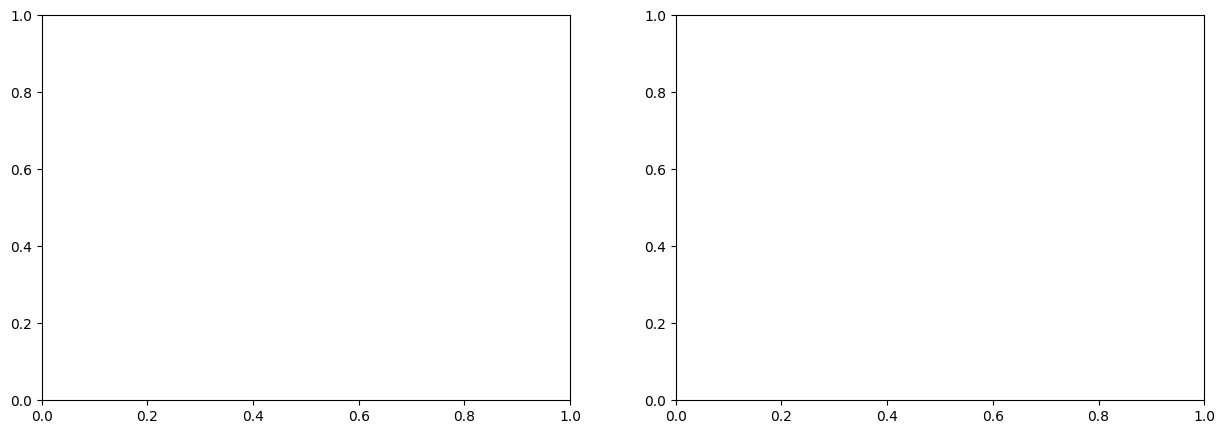

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_acc'], label='Train Accuracy')
axes[0].plot(history['val_acc'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_loss'], label='Train Loss')
axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

best_epoch = np.argmax(history['val_acc'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation accuracy: {history['val_acc'][best_epoch]:.4f}")

In [33]:

def predict_interaction(drug1_smiles, drug2_smiles):
    model.eval()
    
    fp1 = smiles_to_fingerprint(drug1_smiles)
    fp2 = smiles_to_fingerprint(drug2_smiles)
    
    fp1 = torch.FloatTensor(fp1).unsqueeze(0).to(device)
    fp2 = torch.FloatTensor(fp2).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(fp1, fp2)
        probabilities = torch.softmax(outputs, dim=1)[0]
    
    top_probs, top_indices = torch.topk(probabilities, 2)
    
    results = []
    for prob, idx in zip(top_probs, top_indices):
        interaction_type = le.inverse_transform([idx.item()])[0]
        results.append((interaction_type, prob.item()))
    
    return results

In [34]:
def get_smiles_robust(drug_name):
    results = pcp.get_compounds(drug_name, 'name')
    if results:
        compound = results[0]
        return compound.canonical_smiles
    else:
        return None

In [35]:
def get_predictions_for_drugs(drug_name1, drug_name2):
    smiles1 = get_smiles_robust(drug_name1)
    smiles2 = get_smiles_robust(drug_name2)
    
    if smiles1 is None:
        print(f"Could not find SMILES for drug: {drug_name1}")
        return []
    if smiles2 is None:
        print(f"Could not find SMILES for drug: {drug_name2}")
        return []
    
    return predict_interaction(smiles1, smiles2)

In [38]:
model = DDIPredictor()
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.to(device)

prediction = get_predictions_for_drugs('Nimesulide', 'Etacrynic acid')

for i, (interaction, conf) in enumerate(prediction, 1):
    print(f"Interaction: {interaction}")
    print(f"      Confidence: {conf:.2%}")


C:\Users\18605\AppData\Local\Temp\ipykernel_18828\2810630444.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))
C:\U

Interaction: decreased
      Confidence: 94.69%
Interaction: increased
      Confidence: 5.31%
